In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import signal
from scipy.signal import butter, filtfilt, find_peaks, medfilt, sosfiltfilt
from sklearn import preprocessing
%matplotlib notebook

## Functions

In [2]:
#butterworth filter & filtering
def butter_filtering(sig,fs,fc,order,btype): 
    """
    sig: original signal
    fs: sampling frequency
    fc: cut off frequency
    order: order of filter
    btype: type of filter (highpass/lowpass/bandpass)
    
    return: filtered signal
    """
    w = np.array(fc)/(fs/2)
    b, a = butter(order, w, btype =btype, analog=False)
    filtered = filtfilt(b, a, sig)
    return(filtered)

In [34]:
def abp_sig(path_be, path_wav, cust = "Custom1"):
    df_test= pd.read_csv(path_be, delimiter = ';')
    df_wav = pd.read_csv(path_wav, delimiter = ';')
    
    cust_idx = df_test[df_test['Event']==cust]["Time [s]"].to_list()#find the index
    
    abp = df_wav['Pressure [mmHg]'].values[int(cust_idx[0]*100):int(cust_idx[-1]*100)]
    plt.figure(figsize = (6,2))
    plt.plot(abp);plt.ylabel("Blood pressure(mmHg)");plt.xlabel("Sample")
    sbp_loc = find_peaks(abp, distance = 50, height = 80, width = 1, prominence = 1)[0]
    dbp_loc = find_peaks(-1*abp, distance = 50, height = -105, width = 2, prominence = 1)[0]
    plt.plot(sbp_loc, abp[sbp_loc], 'x', label = "SBP location")
    plt.plot(dbp_loc, abp[dbp_loc], 'o', label = "DBP location")
    plt.show()
    return abp


In [4]:
from biosppy.signals import ecg
import neurokit2 as nk
def ecg_ppg_show(path):
    df_sen = pd.read_csv(path, names = ['ts_ecg', 'ecg', 'ts_ppg', 'ppg'])
    
    ecg_sen = df_sen['ecg'].values[5:]
    ppg_sen = df_sen['ppg'].values[5:]

    ecg_f = butter_filtering(ecg_sen, 200, [0.1, 50], 5, 'bandpass')
    ppg_f = butter_filtering(ppg_sen, 200, [0.5, 10], 5, 'bandpass')

    from biosppy.signals import ecg
    ecg_feat = ecg.ecg(1*ecg_f, sampling_rate=200.0, show=True)
    ts = ecg_feat[0]
    filtered = ecg_feat[1]
    rpeaks = ecg_feat[2]
    templates_ts = ecg_feat[3]
    templates = ecg_feat[4]
    heart_rate_ts = ecg_feat[5]
    heart_rate = ecg_feat[6]

    import neurokit2 as nk
    info = nk.ppg_findpeaks(-1*ppg_f, sampling_rate=200, method='elgendi', show=True)
    
    return (ecg_f, ppg_f)

In [5]:
import scipy.stats as st
from sklearn.preprocessing import scale
#ppg features used as calibration
def ppg_features(ppg_f):
    ppg_fn = scale(ppg_f)
    ppg_d = np.gradient(-1*ppg_fn)
    ppg_dd = np.gradient(ppg_d)
    fs = 200
    
    ppg_maxamp = []
    ppg_std = []
    ppg_skew = []
    ppg_kurto = []

    ppg_aimean = []
    ppg_lasimean = []
    
    ppg_aistd = []
    ppg_lasistd=[]
    
    win = 3*200#3s time window
    step = 1*200#1s
    
    for i in range(0, len(ppg_f) - win, int(step)):
        st_idx = i
        end_idx = i+win
        #ppg maxamp
        maxamp = np.ptp(ppg_f[st_idx:end_idx])
        ppg_maxamp.append(maxamp)
        
        #ppg std
        std = np.std(ppg_f[st_idx:end_idx])
        ppg_std.append(std)
        
        #ppg skewness
        skew = st.skew(ppg_f[st_idx:end_idx])
        ppg_skew.append(skew)
        
        #ppg kurtosis
        kur = st.kurtosis(ppg_f[st_idx:end_idx])
        ppg_kurto.append(kur)
        
        #ppg peaks
        info = nk.ppg_findpeaks(-1*ppg_f[st_idx:end_idx], sampling_rate=200, method='elgendi', show=False)#pat-foot
        ppeaks = info['PPG_Peaks']
           
        #ai mean std
        #lasi mean std
        ai = []
        lasi = []
        for p in range(0, len(ppeaks)-1):
            y = ppg_f[st_idx:end_idx][ppeaks[p]]
            dias_peaks2 = find_peaks(ppg_dd[st_idx:end_idx][ppeaks[p]:ppeaks[p+1]], distance = 50, height = 0)[0]
            dias_peaks2+= ppeaks[p]
            dia_p = dias_peaks2[0]
            
            x=ppg_f[st_idx:end_idx][dia_p]
            
            ai.append(x/y)
            lasi.append((dia_p-ppeaks[p])/fs)
            
        ppg_aimean.append(np.mean(ai))
        ppg_lasimean.append(np.mean(lasi))
        
        ppg_aistd.append(np.std(ai))
        ppg_lasistd.append(np.std(lasi))
    return (ppg_maxamp, ppg_std, ppg_skew, ppg_kurto, ppg_aimean, ppg_lasimean, ppg_aistd, ppg_lasistd)


    

In [6]:
def ecg_features(ecg_f):
    win = 3*200#3s time window
    step = 1*200#1s    
    
    hr_lis = []
    
    for i in range(0, len(ecg_f) - win, int(step)):
        st_idx = i
        end_idx = i+win
        rpeaks = ecg.ecg(-1*ecg_f[st_idx:end_idx], sampling_rate=200.0, show=False)[2]
        
        #Use ecg to ectract HR feature
        if i==0:
            start_time = rpeaks[0]/200
        intervals = np.diff(rpeaks)/200
        hr = 60/np.mean(intervals)
        hr_lis.append(hr)
        
    return hr_lis

In [7]:
def pat_features(ecg_f, ppg_f):
    
    win = 3*200#3s time window
    step = 1*200#1s 
    
    ppg_d = np.gradient(-1*ppg_f)
    ppg_dd = np.gradient(ppg_d)
    
    pat_mx=[]
    pat_pk=[]
    pat_ft=[]
    
    for i in range(0, len(ecg_f) - win, int(step)):
        st_idx = i
        end_idx = i+win
        rpeaks = ecg.ecg(-1*ecg_f[st_idx:end_idx], sampling_rate=200.0, show=False)[2]
        
        #pat rpeak to ppg_peak
        info = nk.ppg_findpeaks(-1*ppg_f[st_idx:end_idx], sampling_rate=200, method='elgendi', show=False)
        ppeaks = info['PPG_Peaks']
        
        cor = np.where(ppeaks>=rpeaks[0])
        ppeaks_cor = ppeaks[cor]
    
        maxlen = min(len(ppeaks_cor),len(rpeaks) )
        pk = np.mean((ppeaks_cor[:maxlen] - rpeaks[:maxlen])/200)
        pat_pk.append(pk)
        
        #maximum slope
        maxsl = find_peaks(ppg_d[st_idx:end_idx], distance = 50, height = 10, width = 2, prominence = 1)[0]
        #pat rpeak to maximum slope
        cor2 = np.where(maxsl>=rpeaks[0])
        maxsl_cor = maxsl[cor2]
        
        maxlen = min(len(maxsl_cor),len(rpeaks) )
        ms = np.mean((maxsl_cor[:maxlen] - rpeaks[:maxlen])/200)
        pat_mx.append(ms)
        
        #foot
        info2 = nk.ppg_findpeaks(ppg_f[st_idx:end_idx], sampling_rate=200, method='elgendi', show=False)#pat-foot
        pfoot = info2['PPG_Peaks']
        #pat rpeak to ppg_foot 
        cor3 = np.where(pfoot>=rpeaks[0])
        pfoot_cor = pfoot[cor3]
    
        maxlen = min(len(pfoot_cor),len(rpeaks) )
        ft = np.mean((pfoot_cor[:maxlen] - rpeaks[:maxlen])/200)
        pat_ft.append(ft)    
    return (pat_mx, pat_pk, pat_ft)
    


In [8]:
def sbp_dbp(abp):
    win_bp = 3*100 #3s
    step_bp = 1*100
    sbp_lis = []
    dbp_lis = []

    for i in range(0, len(abp)-win_bp, int(step_bp)):
        st_idx = i
        end_idx = i+win_bp
        
        sbp_loc = find_peaks(abp[st_idx:end_idx],  distance = 50, height = 75, width = 1,prominence=1)[0]
        sbp_mean = np.mean(abp[st_idx:end_idx][sbp_loc])
        sbp_lis.append(sbp_mean)
    
        dbp_loc = find_peaks(-1*abp[st_idx:end_idx], distance = 50, height = -105, width = 2, prominence = 1)[0]
        dbp_mean = np.mean(abp[st_idx:end_idx][dbp_loc])
        dbp_lis.append(dbp_mean)
    return (sbp_lis, dbp_lis)

In [42]:
def visualize(ecg_f, hr_lis, pat_lis, sbp_lis, dbp_lis):#pat_foot
    rpeaks = ecg.ecg(-1*ecg_f, sampling_rate=200.0, show=False)[2]
    start_time = rpeaks[0]/200
    
    ts_hr = np.linspace(5/200+start_time,start_time+ 3/200+1*len(hr_lis), len(hr_lis))
    ts_pat = np.linspace(start_time +5/200, start_time+3/200+1*len(pat_lis), len(pat_lis))
    ts_sbp = np.linspace(0,1*len(sbp_lis), len(sbp_lis) )
    ts_dbp = np.linspace(0,1*len(dbp_lis), len(dbp_lis))
    fig, axs = plt.subplots(4,1,figsize = (6,6), constrained_layout = True)
    ax = axs[0]

    ax.plot(ts_hr, hr_lis, label = "heart rate")
    ax.set_xlabel('time(s)');ax.set_ylabel('HR (bpm)')
    ax.legend()

    ax = axs[1]
    ax.plot(ts_pat, pat_lis, label = "PAT")
    #ax.axvline(x= 10, ls = ':', c = 'g', label = 'start')
    #ax.axvline(x= , ls = '--', c = 'r', label = 'end')
    ax.set_xlabel('time(s)'); ax.set_ylabel('PAT (s)')
    ax.legend()

    ax = axs[2]
    ax.plot(ts_sbp,sbp_lis, label = 'SBP')
    ax.set_xlabel('time(s)'); ax.set_ylabel('BP (mmHg)')
    ax.legend()

    ax= axs[3]
    ax.plot(ts_dbp, dbp_lis, label = 'DBP')
    ax.set_xlabel('time(s)'); ax.set_ylabel('BP (mmHg)')
    ax.legend()    


In [ ]:
def features(ppg_f, ecg_f, abp):
    #200Hz 5s window = 1000samples
#2.5s overlapping step = 500samples
#calculate HR and PATpeak on each 5-second window

    win = 3*200#5s-->3s
    step = 1*200#1s

    hr_lis = []
    pat_lis = []
    sbp_lis = []
    dbp_lis = []

    for i in range(0, len(ecg_f) - win, int(step)):
        st_idx = i
        end_idx = i+win
        rpeaks = ecg.ecg(-1*ecg_f[st_idx:end_idx], sampling_rate=200.0, show=False)[2]
        
        #Use ecg to ectract HR feature
        if i==0:
            start_time = rpeaks[0]/200
        intervals = np.diff(rpeaks)/200
        hr = 60/np.mean(intervals)
        hr_lis.append(hr)
        
        #PAT-foot
        info = nk.ppg_findpeaks(ppg_f[st_idx:end_idx], sampling_rate=200, method='elgendi', show=False)#pat-foot
        ppeaks = info['PPG_Peaks']
        #ppeaks = find_peaks(ppg_f[st_idx:end_idx],  distance = 50, width = 1,prominence=1)[0]
    
        cor = np.where(ppeaks>=rpeaks[0])
        ppeaks_cor = ppeaks[cor]
    
        maxlen = min(len(ppeaks_cor),len(rpeaks) )
        pat = np.mean((ppeaks_cor[:maxlen] - rpeaks[:maxlen])/200)
        pat_lis.append(pat)
    
    win_bp = 3*100 #3s
    step_bp = 1*100

    for i in range(0, len(abp)-win_bp, int(step_bp)):
        st_idx = i
        end_idx = i+win_bp
        sbp_loc = find_peaks(abp[st_idx:end_idx],  distance = 50, height = 75, width = 1,prominence=1)[0]
        sbp_mean = np.mean(abp[st_idx:end_idx][sbp_loc])
        sbp_lis.append(sbp_mean)
    
        dbp_loc = find_peaks(-1*abp[st_idx:end_idx], distance = 50, height = -105, width = 2, prominence = 1)[0]
        dbp_mean = np.mean(abp[st_idx:end_idx][dbp_loc])
        dbp_lis.append(dbp_mean)
    print(len(hr_lis), len(sbp_lis))
    
    ts_hr = np.linspace(5/200+start_time,start_time+ 5/200+2.5*len(hr_lis), len(hr_lis))
    ts_pat = np.linspace(start_time +5/200, start_time+5/200+2.5*len(pat_lis), len(pat_lis))
    ts_sbp = np.linspace(0,2.5*len(sbp_lis), len(sbp_lis) )
    ts_dbp = np.linspace(0,2.5*len(dbp_lis), len(dbp_lis))
    fig, axs = plt.subplots(4,1,figsize = (6,4), constrained_layout = True)
    ax = axs[0]
    #ax.set_title('valsalva maneuver 10s')
    ax.plot(ts_hr, hr_lis, label = "heart rate")
    ax.set_xlabel('time(s)');ax.set_ylabel('heart rate (bpm)')
    ax.legend()

    ax = axs[1]
    ax.plot(ts_pat, pat_lis, label = "PAT")
    #ax.axvline(x= 10, ls = ':', c = 'g', label = 'start')
    #ax.axvline(x= , ls = '--', c = 'r', label = 'end')
    ax.set_xlabel('time(s)'); ax.set_ylabel('PAT (s)')
    ax.legend()

    ax = axs[2]
    ax.plot(ts_sbp,sbp_lis, label = 'SBP')
    ax.set_xlabel('time(s)'); ax.set_ylabel('BP (mmHg)')
    ax.legend()

    ax= axs[3]
    ax.plot(ts_dbp, dbp_lis, label = 'DBP')
    ax.set_xlabel('time(s)'); ax.set_ylabel('BP (mmHg)')
    ax.legend()
    
    return (hr_lis, pat_lis, sbp_lis, dbp_lis)

In [10]:
import os
def filename_lis(path_fo, name):
    filename = []
    lis = os.listdir(path_fo)
    for f in lis:
        if name in f:
            filename.append(f)
    return filename

In [11]:
def findfiles(files_path, files_list, name):
    
    files = os.listdir(files_path)
    for s in files:
        s_path = os.path.join(files_path, s)
        if os.path.isdir(s_path):
            findfiles(s_path, files_list, name)
        elif os.path.isfile(s_path) and name in s:
            result.append(s_path)

## Load data

In [47]:
#1751
path_wav =  '../Jukka_216/CNAP_2022-02-16_18-48-20_001_waveform.csv'
path_bet =  '../Jukka_216/CNAP_2022-02-16_18-48-20_001_beats.csv'
path_sen = '../Jukka_216/2022-02-16-17-51-59/2022-02-16-17-51-59.csv'

<IPython.core.display.Javascript object>


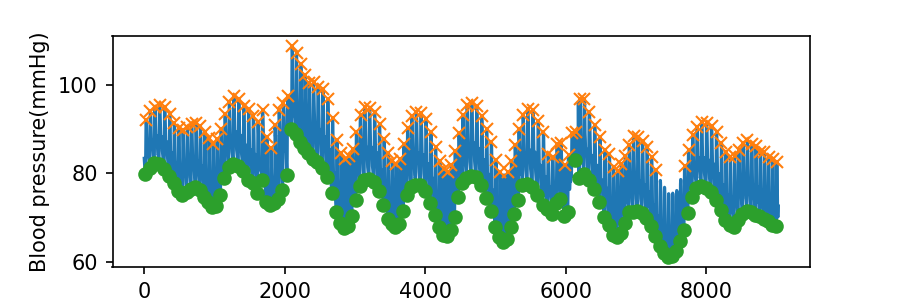

In [48]:
abp = abp_sig(path_bet, path_wav)

<IPython.core.display.Javascript object>


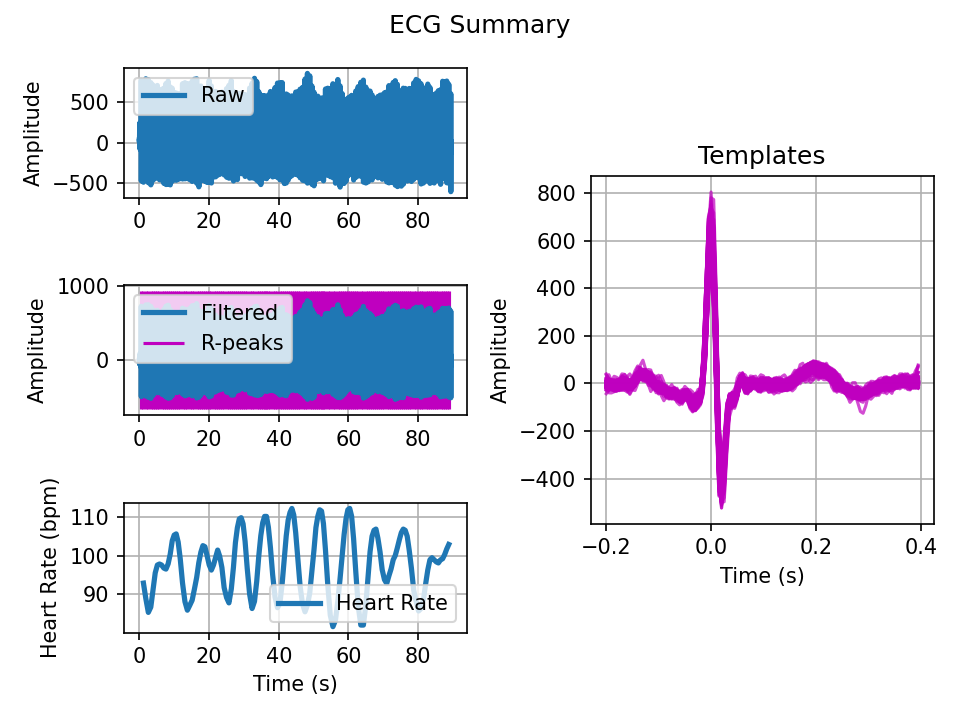

<IPython.core.display.Javascript object>


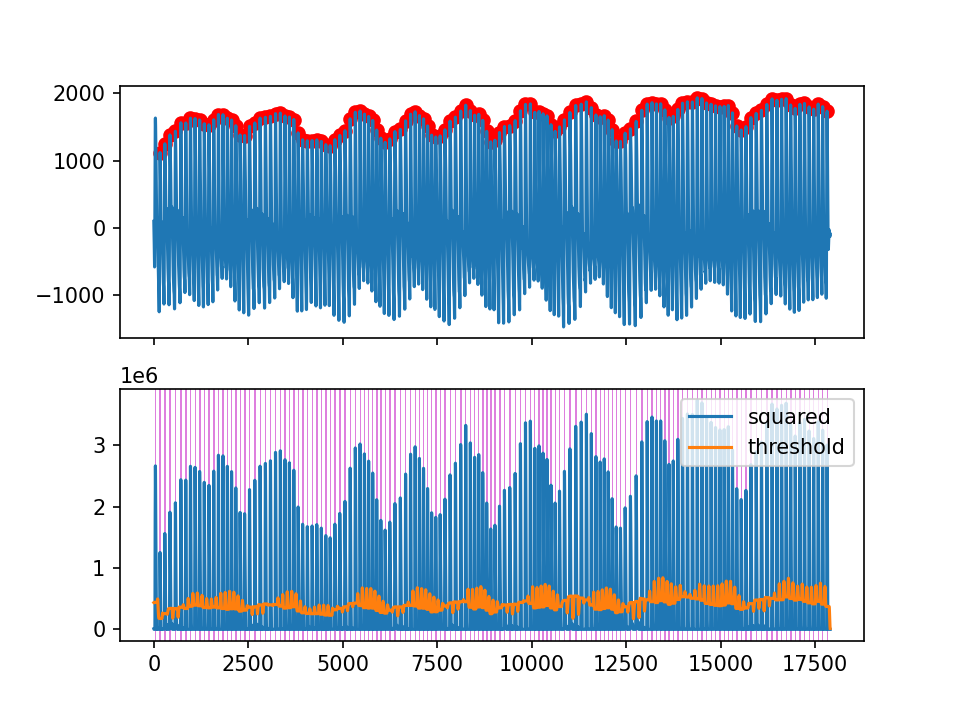

In [49]:
ecg_f, ppg_f = ecg_ppg_show(path_sen)

In [50]:
ppg_maxamp, ppg_std, ppg_skew, ppg_kurto, ppg_aimean, ppg_lasimean, ppg_aistd, ppg_lasistd = ppg_features(ppg_f)

In [51]:
hr_lis = ecg_features(ecg_f)
#print(hr_lis)
#print(len(hr_lis))

<IPython.core.display.Javascript object>


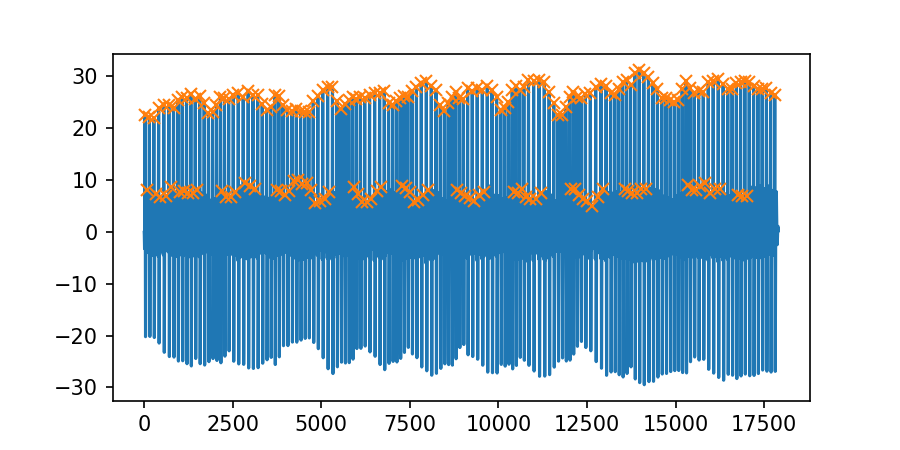

In [52]:
ppg_fn = scale(ppg_f)
ppg_d = np.gradient(-1*ppg_f)
ppg_dd = np.gradient(ppg_d)
s = find_peaks(ppg_dd, distance = 50, height = 2, width = 2, prominence = 1)[0]
plt.figure(figsize = (6,3))
#plt.plot(-1*ppg_f)
plt.plot(ppg_dd)
plt.plot(s, ppg_dd[s], 'x')

In [53]:
pat_mx, pat_pk, pat_ft = pat_features(ecg_f, ppg_f)

In [54]:
sbp_lis, dbp_lis = sbp_dbp(abp)

In [20]:
len(dbp_lis)

88

In [21]:
len(pat_ft)

87

<IPython.core.display.Javascript object>


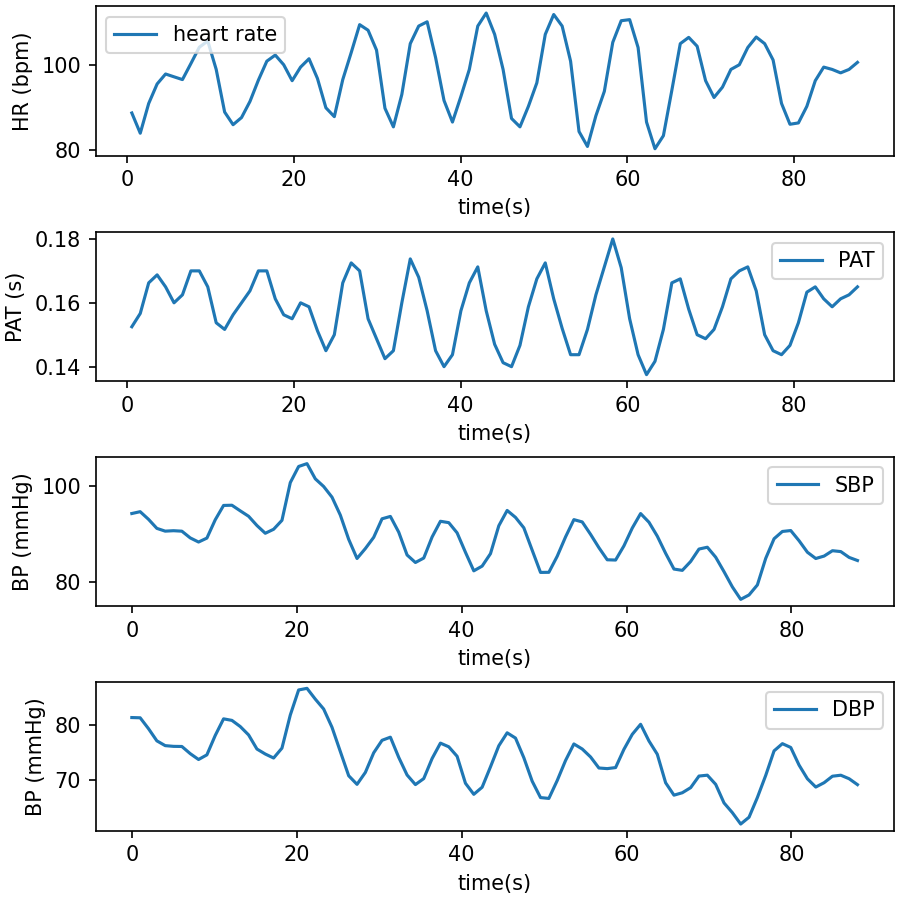

In [55]:
visualize(ecg_f, hr_lis, pat_ft, sbp_lis, dbp_lis)

In [56]:
df_1751 = pd.DataFrame({'mxamp':ppg_maxamp, 'std':ppg_std, 'skew':ppg_skew, 'kurtosis':ppg_kurto, 'aimean':ppg_aimean, 'lasimean':ppg_lasimean, 'aistd':ppg_aistd, 'lasistd':ppg_lasistd,'hr':hr_lis, 'patmx':pat_mx, 'patpk':pat_pk, 'patft':pat_ft, 'sbp':sbp_lis[-87:], 'dbp':dbp_lis[-87:]})
df_1751

mxamp         std      skew  kurtosis    aimean  lasimean     aistd  \
0   2879.176501  751.728982 -0.229849 -0.933357  0.021117  0.155000  0.138829   
1   2765.073311  719.716591 -0.357917 -0.762510  0.105587  0.160000  0.030531   
2   2833.671027  778.133839 -0.388241 -0.945357 -0.040858  0.158333  0.092396   
3   2783.069263  743.363892 -0.791137 -0.341928 -0.116708  0.156667  0.038513   
4   2804.659607  790.950755 -0.638073 -0.764912 -0.123920  0.165000  0.021637   
..          ...         ...       ...       ...       ...       ...       ...   
82  3173.715626  897.657801 -0.814304 -0.634294 -0.083395  0.151250  0.010653   
83  3173.715626  908.947369 -0.753606 -0.697045 -0.084848  0.161667  0.010297   
84  3103.513620  888.341656 -0.740896 -0.673419 -0.100341  0.151667  0.023500   
85  3076.952607  855.448047 -0.872162 -0.463835 -0.118626  0.146667  0.017064   
86  2919.653012  836.084374 -0.946870 -0.373441 -0.130535  0.141667  0.003247   

     lasistd          hr    patmx   patpk     patft      sbp      dbp  
0   0.004082   88.669951 -0.33875  0.2675  0.152500  94.6700  81.2350  
1   0.004082   83.916084 -0.18000  1.1150  0.156667  93.0820  79.2700  
2   0.004714   90.909091 -0.30875  1.5975  0.166250  91.2000  77.0750  
3   0.002357   95.490716 -0.26875  2.1600  0.168750  90.6220  76.2120  
4   0.004082   97.826087 -0.24875  1.4950  0.165000  90.7125  76.0800  
..       ...         ...      ...     ...       ...      ...      ...  
82  0.011388   99.447514 -0.24000  1.4725  0.161250  85.4380  69.5240  
83  0.002357   98.901099 -0.17000  2.0900  0.158750  86.5525  70.6925  
84  0.006236   98.092643 -0.25875  1.4950  0.161250  86.3700  70.8720  
85  0.002357   98.901099 -0.25625  2.0950  0.162500  85.1580  70.2360  
86  0.002357  100.558659 -0.24375  1.5200  0.165000  84.5140  69.1700  

[87 rows x 14 columns]

In [25]:
df_1751.to_csv("../j_prepared_data/1751_all.csv", index = False)

<IPython.core.display.Javascript object>


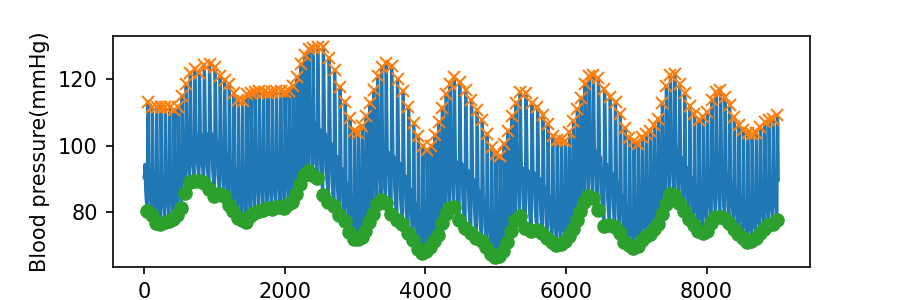

<IPython.core.display.Javascript object>


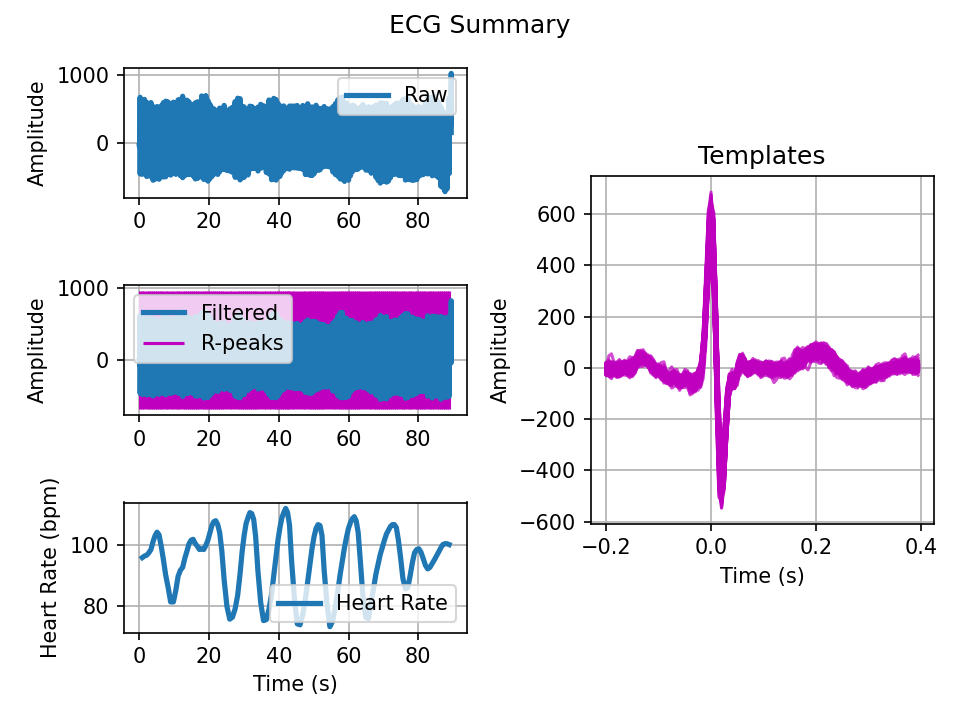

<IPython.core.display.Javascript object>


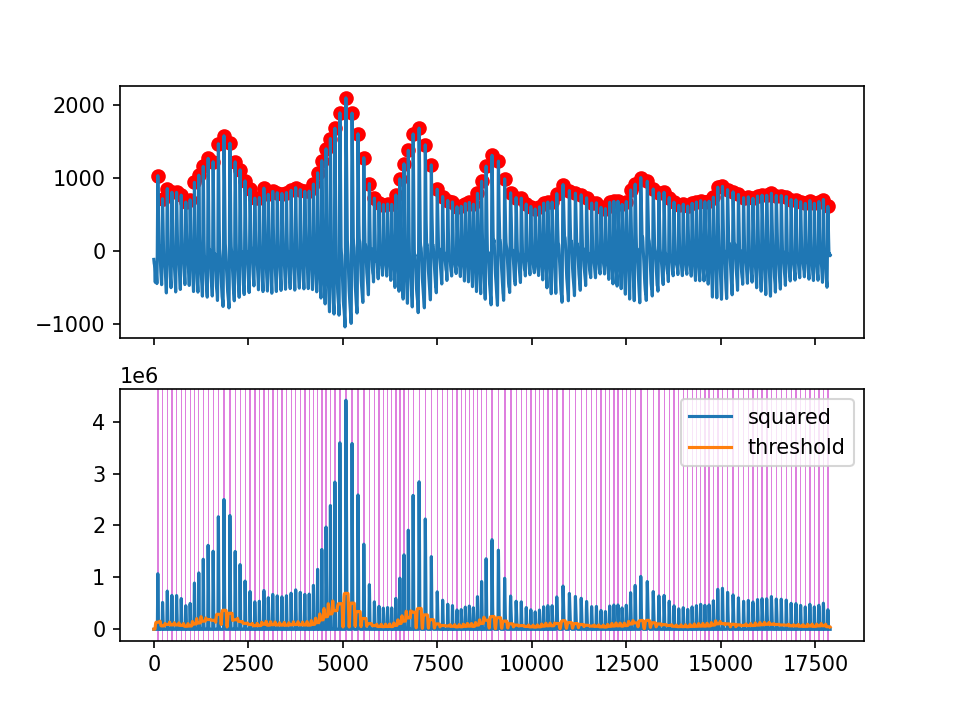

<IPython.core.display.Javascript object>


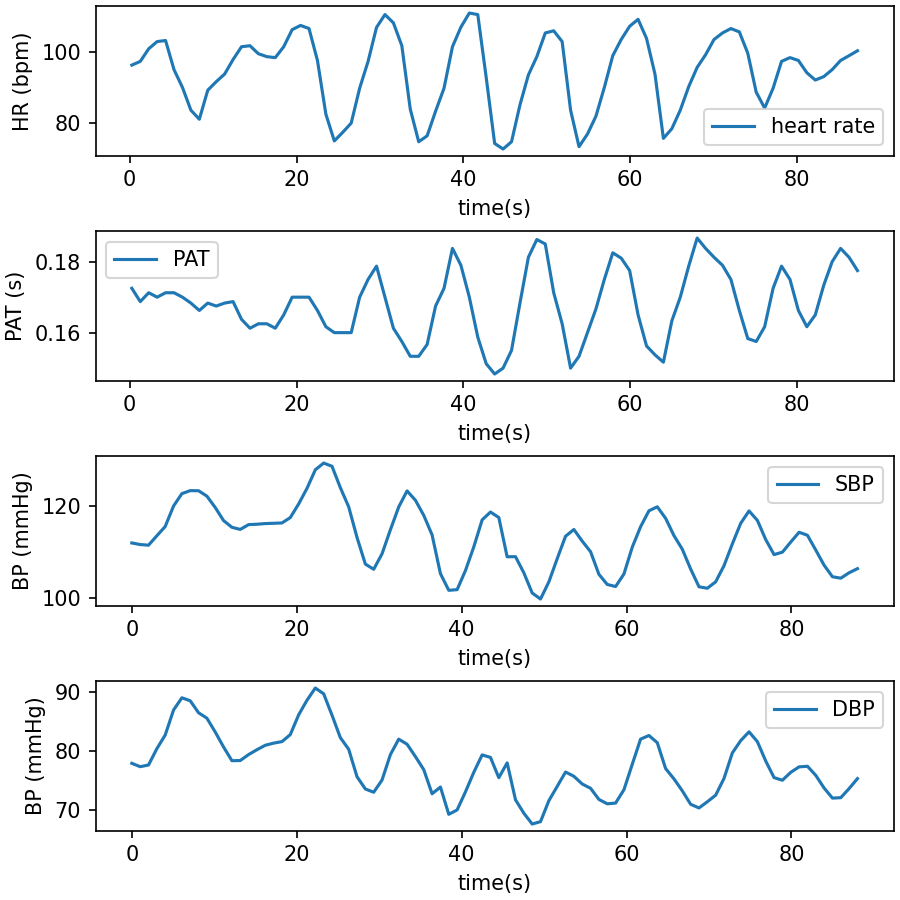

In [46]:
#1801
path_wav =  '../Jukka_216/CNAP_2022-02-16_18-58-20_001_waveform.csv'
path_bet =  '../Jukka_216/CNAP_2022-02-16_18-58-20_001_beats.csv'
path_sen = '../Jukka_216/2022-02-16-18-01-27/2022-02-16-18-01-27.csv'

abp = abp_sig(path_bet, path_wav)
ecg_f, ppg_f = ecg_ppg_show(path_sen)
ppg_maxamp, ppg_std, ppg_skew, ppg_kurto, ppg_aimean, ppg_lasimean, ppg_aistd, ppg_lasistd = ppg_features(ppg_f)
hr_lis = ecg_features(ecg_f)
pat_mx, pat_pk, pat_ft = pat_features(ecg_f, ppg_f)
sbp_lis, dbp_lis = sbp_dbp(abp)
visualize(ecg_f, hr_lis, pat_ft, sbp_lis, dbp_lis)

In [28]:
len(pat_pk)

87

In [29]:
df_1801 = pd.DataFrame({'mxamp':ppg_maxamp, 'std':ppg_std, 'skew':ppg_skew, 'kurtosis':ppg_kurto, 'aimean':ppg_aimean, 'lasimean':ppg_lasimean, 'aistd':ppg_aistd, 'lasistd':ppg_lasistd,'hr':hr_lis, 'patmx':pat_mx, 'patpk':pat_pk, 'patft':pat_ft, 'sbp':sbp_lis[-87:], 'dbp':dbp_lis[-87:]})
df_1801

mxamp         std      skew  kurtosis    aimean  lasimean     aistd  \
0   1602.931720  376.255693 -0.954621  0.072679 -0.051260  0.150000  0.067819   
1   1426.943683  369.373514 -0.688561 -0.440830 -0.047517  0.150000  0.017105   
2   1363.278257  352.684067 -0.710984 -0.417952 -0.062187  0.148750  0.028523   
3   1600.255762  387.271321 -0.764692 -0.286667 -0.106417  0.145000  0.034330   
4   1774.627823  413.509253 -0.942128  0.122240  0.260868  0.088333  0.290898   
..          ...         ...       ...       ...       ...       ...       ...   
82  1321.727144  362.926403 -0.709038 -0.644337  0.030047  0.150000  0.014765   
83  1215.306688  317.559676 -0.913546 -0.240831  0.000339  0.133333  0.026804   
84  1113.052589  313.863996 -0.907041 -0.368782  0.009499  0.128333  0.037946   
85  1093.523430  305.438655 -0.956391 -0.231155  0.028549  0.123333  0.019802   
86  1133.244689  317.697719 -0.844829 -0.447457  0.006441  0.130000  0.017750   

     lasistd          hr    patmx    patpk     patft       sbp      dbp  
0   0.000000   96.256684  0.23875  0.29625  0.172500  111.6540  77.2880  
1   0.004082   97.297297  0.23250  1.52250  0.168750  111.5120  77.5720  
2   0.006495  100.840336  0.23250  1.48500  0.171250  113.5720  80.3440  
3   0.007071  102.857143  0.23375  2.03500  0.170000  115.6040  82.6680  
4   0.036591  103.151862  0.23625  1.47500  0.171250  120.0800  86.9220  
..       ...         ...      ...      ...       ...       ...      ...  
82  0.012247   93.023256  0.23500  1.59000  0.173333  107.1260  73.6560  
83  0.002357   94.986807  0.24250  1.60000  0.180000  104.5975  71.9425  
84  0.006236   97.560976  0.24500  1.53000  0.183750  104.2840  72.0160  
85  0.004714   98.901099  0.24375  2.11500  0.181250  105.4740  73.5720  
86  0.007071  100.278552  0.23875  1.51000  0.177500  106.3720  75.2625  

[87 rows x 14 columns]

In [30]:
df_1801.to_csv("../j_prepared_data/1801_all.csv", index = False)

<IPython.core.display.Javascript object>


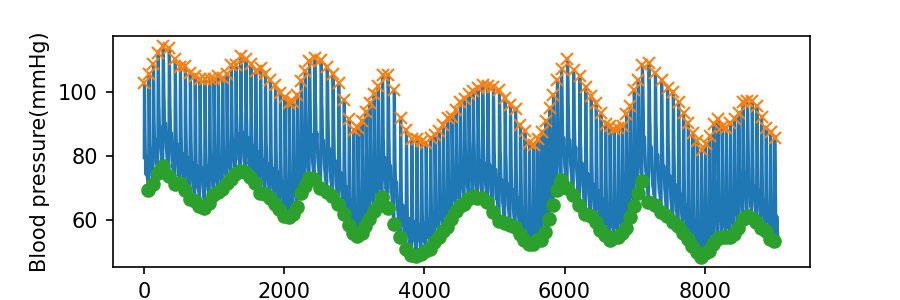

<IPython.core.display.Javascript object>


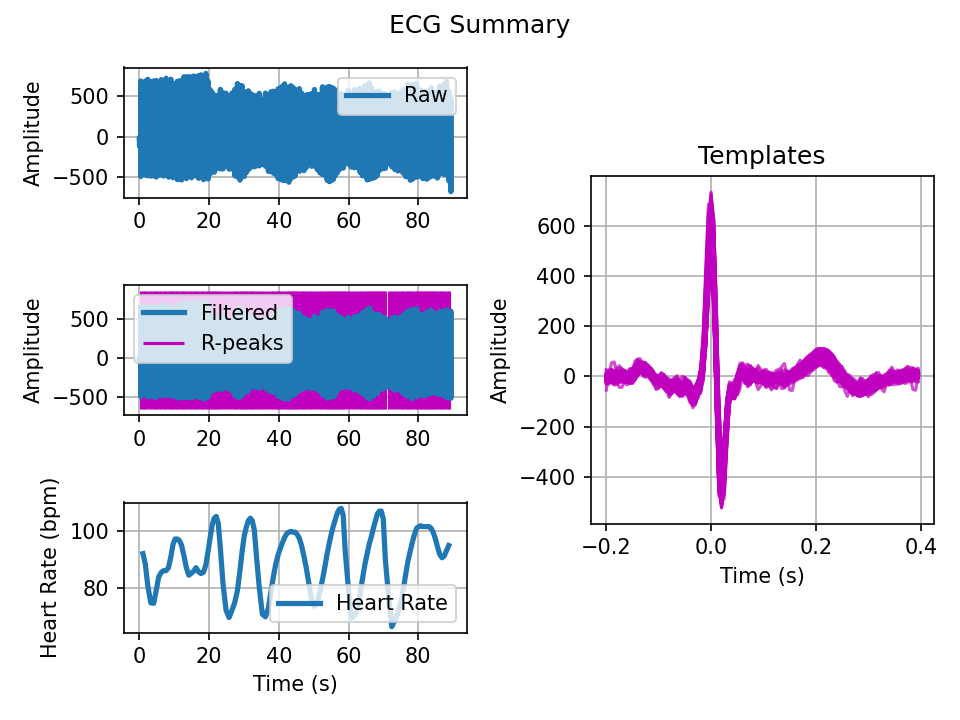

<IPython.core.display.Javascript object>


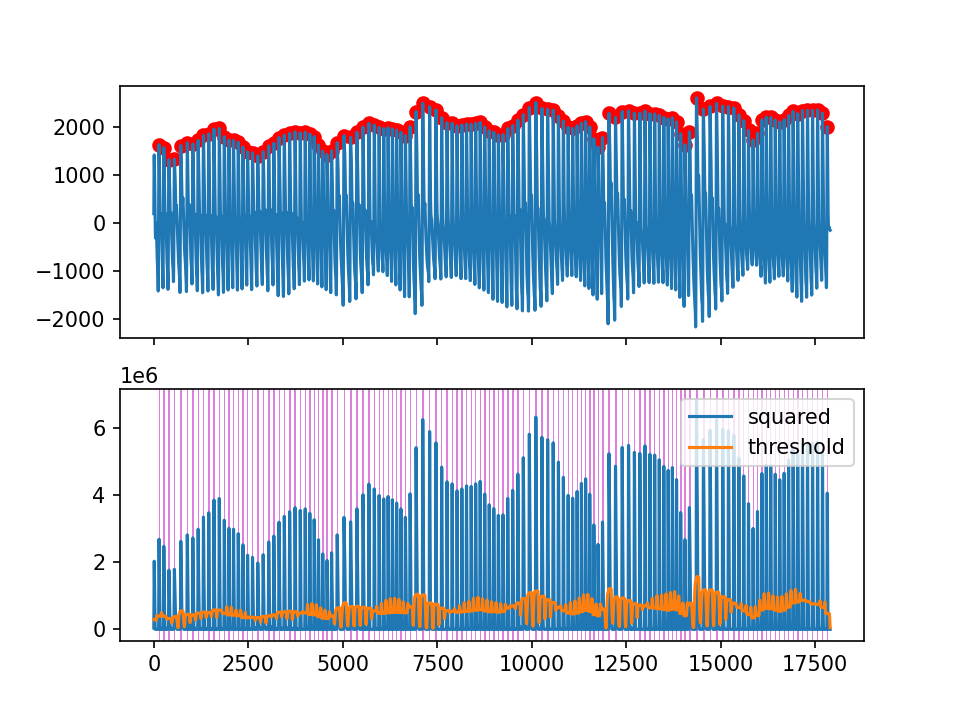

<IPython.core.display.Javascript object>


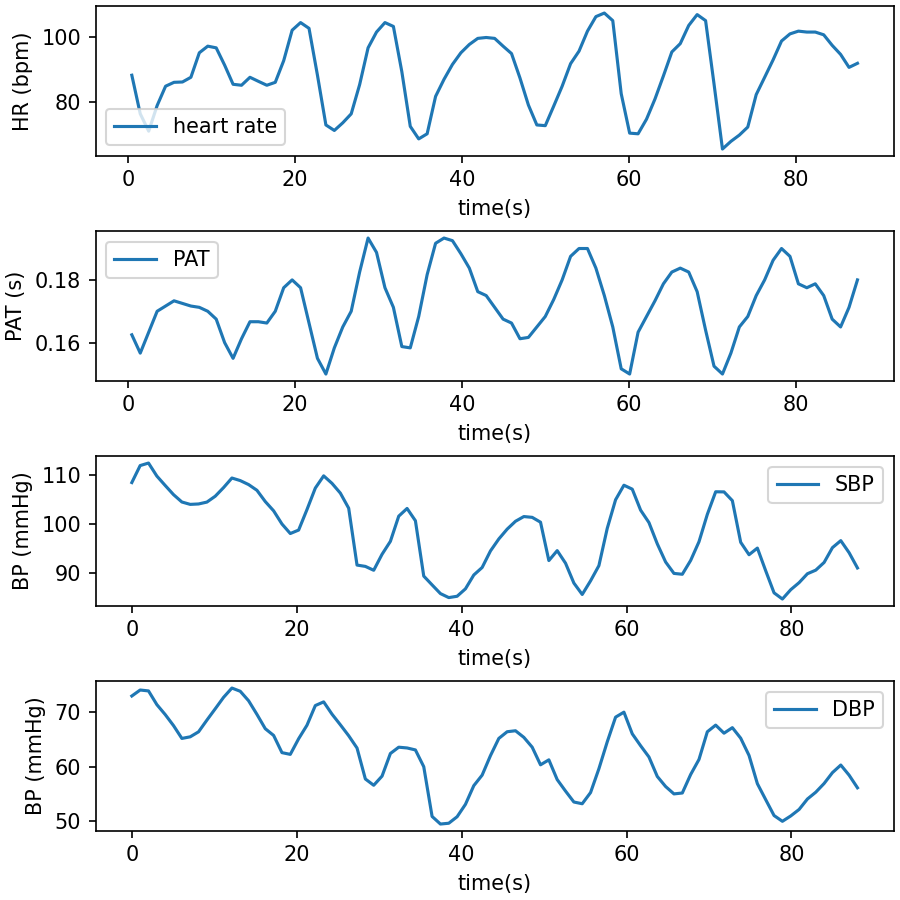

87 88


In [45]:
#1810

path_wav =  '../Jukka_216/CNAP_2022-02-16_19-07-27_001_waveform.csv'
path_bet = '../Jukka_216/CNAP_2022-02-16_19-07-27_001_beats.csv'
path_sen = '../Jukka_216//2022-02-16-18-10-49/2022-02-16-18-10-49.csv'

abp = abp_sig(path_bet, path_wav)
ecg_f, ppg_f = ecg_ppg_show(path_sen)
ppg_maxamp, ppg_std, ppg_skew, ppg_kurto, ppg_aimean, ppg_lasimean, ppg_aistd, ppg_lasistd = ppg_features(ppg_f)
hr_lis = ecg_features(ecg_f)
pat_mx, pat_pk, pat_ft = pat_features(ecg_f, ppg_f)
sbp_lis, dbp_lis = sbp_dbp(abp)
visualize(ecg_f, hr_lis, pat_ft, sbp_lis, dbp_lis)
print(len(pat_pk), len(sbp_lis))

In [32]:
df_1810 = pd.DataFrame({'mxamp':ppg_maxamp, 'std':ppg_std, 'skew':ppg_skew, 'kurtosis':ppg_kurto, 'aimean':ppg_aimean, 'lasimean':ppg_lasimean, 'aistd':ppg_aistd, 'lasistd':ppg_lasistd,'hr':hr_lis, 'patmx':pat_mx, 'patpk':pat_pk, 'patft':pat_ft, 'sbp':sbp_lis[-87:], 'dbp':dbp_lis[-87:]})
df_1810

mxamp          std      skew  kurtosis    aimean  lasimean  \
0   3048.119590   804.877644 -0.105865 -0.959559  0.041109  0.165000   
1   3060.471277   812.197457 -0.113295 -0.998956  0.129290  0.170000   
2   3118.766852   800.416873 -0.189812 -0.931089  0.238883  0.175000   
3   3168.144547   874.555414 -0.318253 -0.955278  0.090283  0.171667   
4   3275.703668   863.391023 -0.407753 -0.745936  0.028973  0.171667   
..          ...          ...       ...       ...       ...       ...   
82  3749.626889  1023.601147 -0.864499 -0.482810  0.037090  0.133333   
83  3974.872647  1120.250263 -0.692616 -0.769969  0.039954  0.146250   
84  3980.151315  1126.181003 -0.689253 -0.685224  0.055306  0.156667   
85  3985.989745  1166.997427 -0.569462 -0.873771  0.072470  0.153333   
86  3900.860070  1045.294348 -0.926553 -0.128847  0.077705  0.146667   

       aistd   lasistd          hr     patmx    patpk     patft       sbp  \
0   0.056711  0.004082   88.235294 -0.318750  0.27875  0.162500  112.0125   
1   0.076878  0.004082   76.190476 -0.220000  1.20250  0.156667  112.5300   
2   0.006135  0.000000   70.796460 -0.256667  1.98000  0.163333  109.8550   
3   0.111250  0.002357   78.774617 -0.391250  1.79500  0.170000  107.9250   
4   0.030345  0.002357   84.805654 -0.150000  1.05750  0.171667  106.0400   
..       ...       ...         ...       ...      ...       ...       ...   
82  0.014965  0.008498  100.840336  0.235000  1.48750  0.175000   92.1120   
83  0.016669  0.010825   97.560976  0.226250  1.50500  0.167500   95.1520   
84  0.013310  0.004714   94.736842  0.223750  2.18000  0.165000   96.5900   
85  0.007846  0.006236   90.680101  0.228750  1.61250  0.171250   94.1060   
86  0.007332  0.006236   91.954023  0.238333  1.60000  0.180000   90.9800   

          dbp  
0   74.032500  
1   73.866667  
2   71.360000  
3   69.540000  
4   67.512000  
..        ...  
82  56.912500  
83  58.902000  
84  60.290000  
85  58.430000  
86  56.122000  

[87 rows x 14 columns]

In [33]:
df_1810.to_csv("../j_prepared_data/1810_all.csv", index = False)

<IPython.core.display.Javascript object>


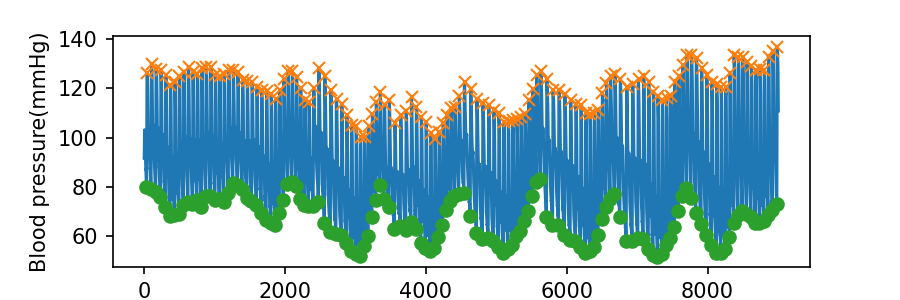

<IPython.core.display.Javascript object>


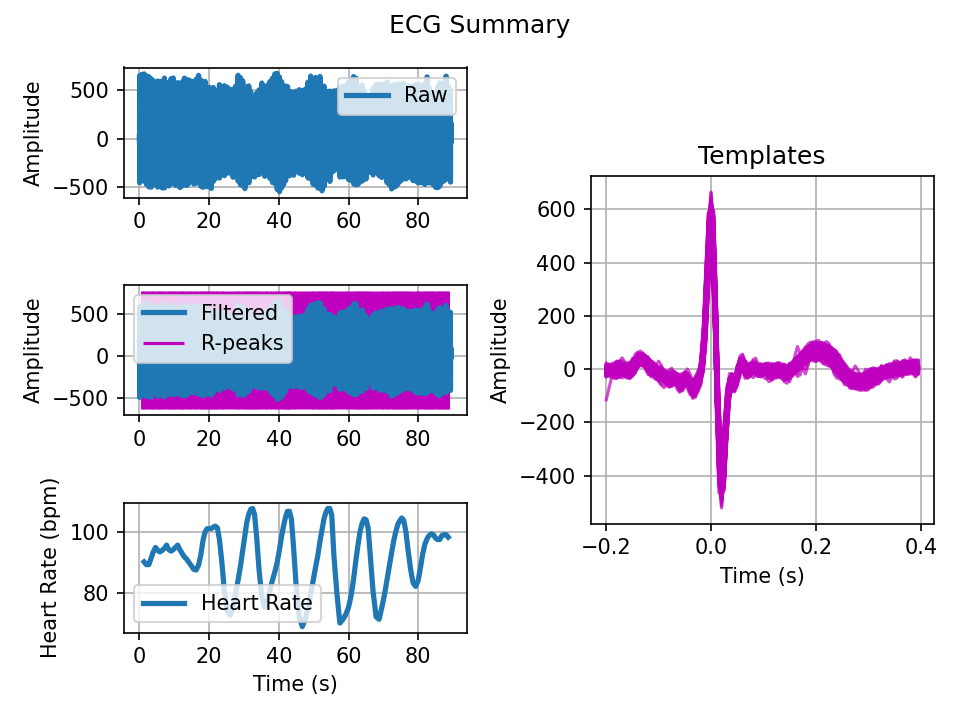

<IPython.core.display.Javascript object>


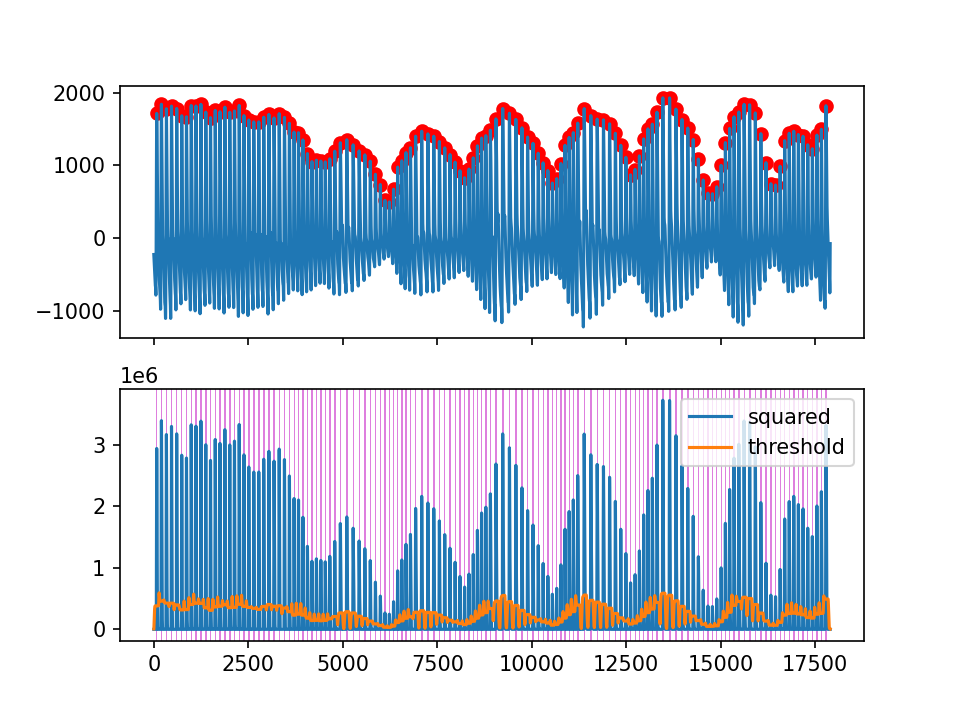

<IPython.core.display.Javascript object>


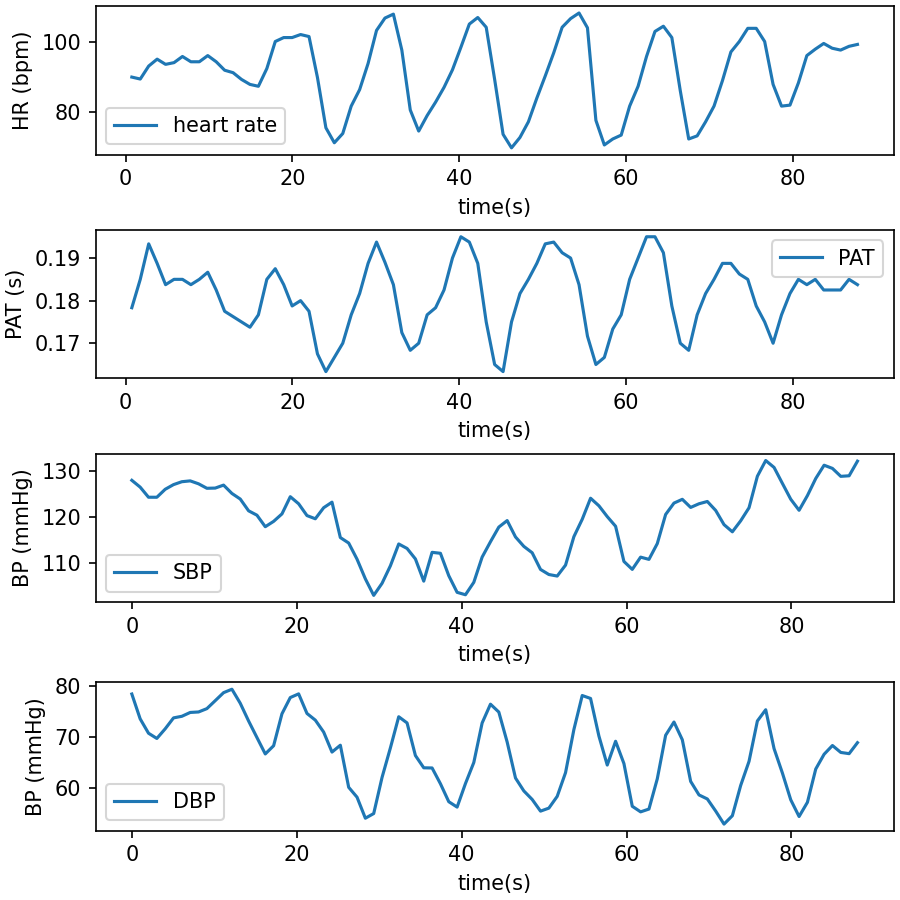

88 87


In [43]:
#1818 custom2
path_wav =  '../Jukka_216/CNAP_2022-02-16_19-14-47_001_waveform.csv'
path_bet =  '../Jukka_216/CNAP_2022-02-16_19-14-47_001_beats.csv'
path_sen = '../Jukka_216/2022-02-16-18-18-05/2022-02-16-18-18-05.csv'

abp = abp_sig(path_bet, path_wav, cust = "Custom2")
ecg_f, ppg_f = ecg_ppg_show(path_sen)
ppg_maxamp, ppg_std, ppg_skew, ppg_kurto, ppg_aimean, ppg_lasimean, ppg_aistd, ppg_lasistd = ppg_features(ppg_f)
hr_lis = ecg_features(ecg_f)
pat_mx, pat_pk, pat_ft = pat_features(ecg_f, ppg_f)
sbp_lis, dbp_lis = sbp_dbp(abp)
visualize(ecg_f, hr_lis, pat_ft, sbp_lis, dbp_lis)
print(len(sbp_lis), len(pat_pk))

In [36]:
df_1818 = pd.DataFrame({'mxamp':ppg_maxamp, 'std':ppg_std, 'skew':ppg_skew, 'kurtosis':ppg_kurto, 'aimean':ppg_aimean, 'lasimean':ppg_lasimean, 'aistd':ppg_aistd, 'lasistd':ppg_lasistd,'hr':hr_lis, 'patmx':pat_mx, 'patpk':pat_pk, 'patft':pat_ft, 'sbp':sbp_lis[-87:], 'dbp':dbp_lis[-87:]})
df_1818

mxamp         std      skew  kurtosis    aimean  lasimean     aistd  \
0   2950.090281  786.312979 -0.917113 -0.181665  0.088592  0.141667  0.010712   
1   2950.090281  786.050246 -0.739093 -0.389234  0.100281  0.140000  0.019647   
2   2931.243334  782.437767 -0.890697 -0.260713  0.220857  0.113333  0.164660   
3   2827.385104  759.003527 -0.865855 -0.265328  0.344514  0.088333  0.195164   
4   2883.310961  799.294520 -0.841365 -0.417405  0.189390  0.118750  0.185808   
..          ...         ...       ...       ...       ...       ...       ...   
82  2211.281128  541.139810 -1.036639  0.217041  0.505183  0.061667  0.036120   
83  2211.281128  624.562598 -0.966008 -0.307295  0.503537  0.065000  0.028556   
84  2211.281128  611.280575 -1.002214 -0.210002  0.464839  0.068333  0.019184   
85  2086.135212  580.698489 -1.014081 -0.156255  0.444513  0.066667  0.019931   
86  2788.843353  656.345618 -1.015301  0.088205  0.451808  0.065000  0.021500   

     lasistd         hr     patmx   patpk     patft       sbp      dbp  
0   0.004714  89.887640  0.236667  0.2900  0.178333  126.4520  73.5075  
1   0.004082  89.330025  0.243750  1.6450  0.185000  124.2750  70.7080  
2   0.034238  93.023256  0.250000  1.5900  0.193333  124.2680  69.6850  
3   0.036591  94.986807  0.246250  1.5825  0.188750  125.9860  71.5660  
4   0.033981  93.506494  0.241250  1.5825  0.183750  126.9950  73.6950  
..       ...        ...       ...     ...       ...       ...      ...  
82  0.002357  99.447514  0.252500  1.5075  0.182500  131.1780  66.6080  
83  0.003536  98.092643  0.250000  1.5225  0.182500  130.4900  68.3140  
84  0.002357  97.560976  0.251250  1.5900  0.182500  128.7775  66.9625  
85  0.002357  98.630137  0.252500  1.5225  0.185000  128.9000  66.7260  
86  0.000000  99.173554  0.251250  2.1100  0.183750  132.0500  68.8660  

[87 rows x 14 columns]

In [37]:
df_1818.to_csv("../j_prepared_data/1818_all.csv", index = False)

<IPython.core.display.Javascript object>


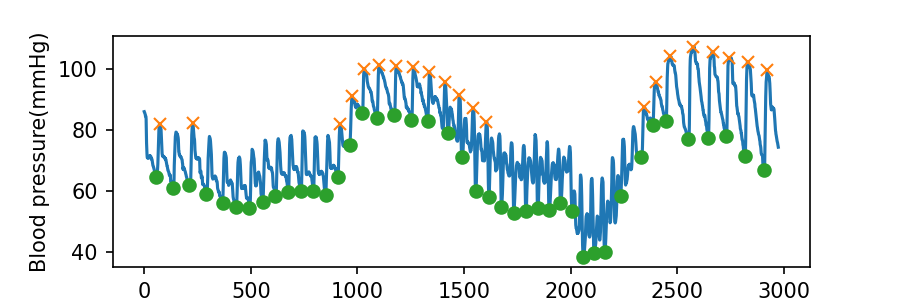

<IPython.core.display.Javascript object>


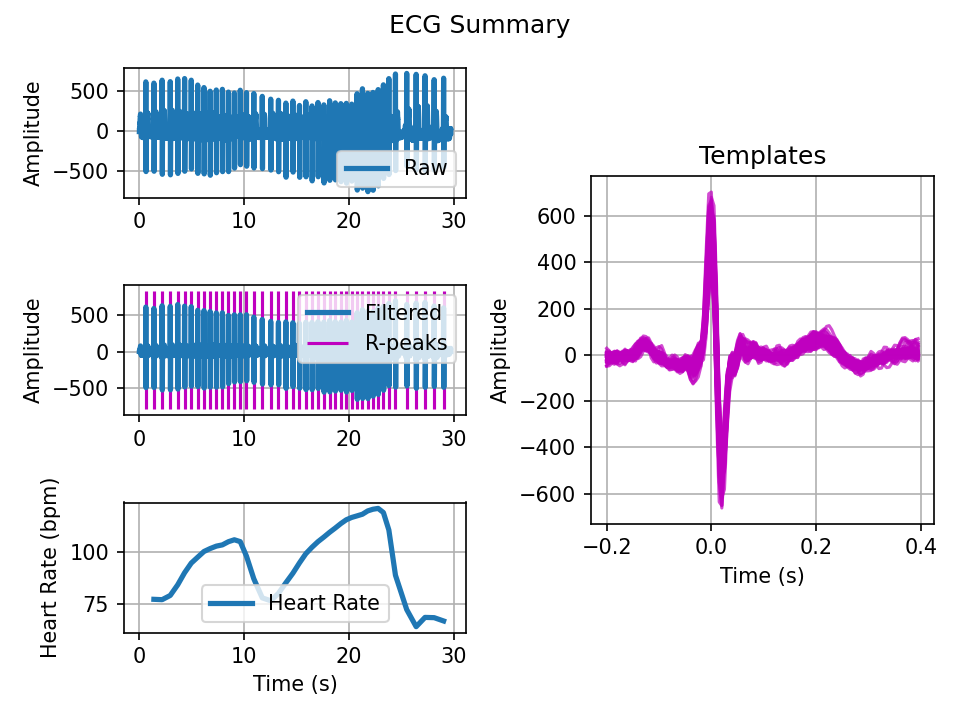

<IPython.core.display.Javascript object>


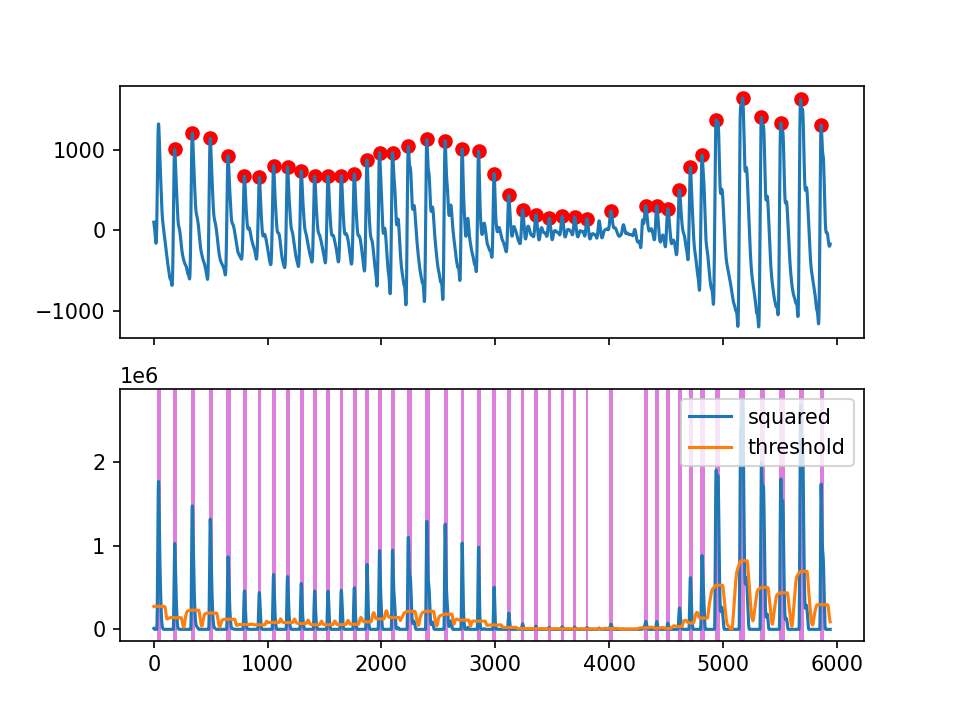

C:\Users\HP\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\HP\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


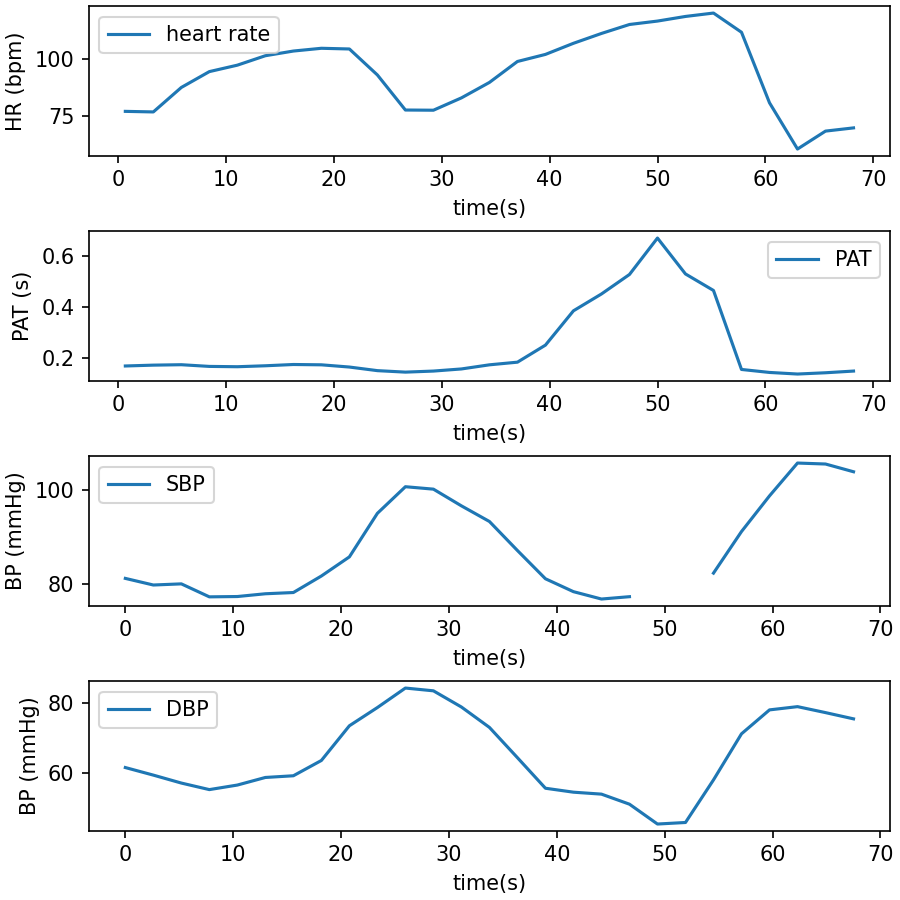

27 27


In [38]:
#1824 exclude. extremely low bp
path_wav =  '../Jukka_216/CNAP_2022-02-16_19-21-43_001_waveform.csv'
path_bet =  '../Jukka_216/CNAP_2022-02-16_19-21-43_001_beats.csv'
path_sen = '../Jukka_216/2022-02-16-18-24-42/2022-02-16-18-24-42.csv'

abp = abp_sig(path_bet, path_wav)
ecg_f, ppg_f = ecg_ppg_show(path_sen)
ppg_maxamp, ppg_std, ppg_skew, ppg_kurto, ppg_aimean, ppg_lasimean, ppg_aistd, ppg_lasistd = ppg_features(ppg_f)
hr_lis = ecg_features(ecg_f)
pat_mx, pat_pk, pat_ft = pat_features(ecg_f, ppg_f)
sbp_lis, dbp_lis = sbp_dbp(abp)
visualize(ecg_f, hr_lis, pat_ft, sbp_lis, dbp_lis)
print(len(sbp_lis), len(pat_pk))

In [34]:
df_181129 = pd.DataFrame({'mxamp':ppg_maxamp, 'std':ppg_std, 'skew':ppg_skew, 'kurtosis':ppg_kurto, 'aimean':ppg_aimean, 'lasimean':ppg_lasimean, 'aistd':ppg_aistd, 'lasistd':ppg_lasistd,'hr':hr_lis, 'patmx':pat_mx, 'patpk':pat_pk, 'patft':pat_ft, 'sbp':sbp_lis[-87:], 'dbp':dbp_lis[-87:]})
df_181129

mxamp         std      skew  kurtosis    aimean  lasimean     aistd  \
0   1927.188127  538.144567  0.022529 -1.297479  0.565918  0.097500  0.223980   
1   1927.188127  566.926069  0.093084 -1.362503  0.752557  0.055000  0.000000   
2   1927.188127  576.559503  0.302254 -1.311564  0.783617  0.050000  0.005686   
3   1857.453208  516.240773  0.236320 -1.168878  0.788149  0.047500  0.001154   
4   1833.106311  506.285467  0.062771 -1.240368  0.759950  0.047500  0.027046   
..          ...         ...       ...       ...       ...       ...       ...   
82  1874.386682  506.819392 -0.141387 -1.215751  0.583513  0.102500  0.198989   
83  1880.628836  527.228365 -0.204149 -1.216403  0.351472  0.152500  0.033052   
84  1934.225542  552.818758 -0.064354 -1.307452  0.638481  0.083333  0.226781   
85  1934.225542  568.988263  0.024566 -1.307345  0.787328  0.050000  0.006567   
86  1934.225542  539.497445 -0.158269 -1.234076  0.800187  0.050000  0.006292   

    lasistd         hr     patmx   patpk     patft         sbp        dbp  
0   0.05250  72.072072  0.275000  0.3350  0.216667  107.900000  81.297500  
1   0.00000  68.181818  0.266667  1.2900  0.206667  107.810000  80.745000  
2   0.00000  65.573770  0.268333  1.3425  0.208333  108.017500  79.920000  
3   0.00250  68.571429  0.276667  1.3450  0.216667  104.595000  79.716667  
4   0.00250  73.170732  0.278333  1.9650  0.216667  105.656667  79.020000  
..      ...        ...       ...     ...       ...         ...        ...  
82  0.05250  74.303406  0.263333  1.9500  0.198333  108.035000  80.665000  
83  0.00250  78.260870  0.263750  1.8650  0.198750  106.657500  78.776667  
84  0.04714  78.175896  0.258333  1.1475  0.193333  105.876667  79.525000  
85  0.00000  76.190476  0.255000  1.8900  0.191667  107.995000  80.095000  
86  0.00000  75.000000  0.258333  1.9250  0.195000  108.352500  79.962500  

[87 rows x 14 columns]

In [ ]:
df_181129.to_csv("../c_prepared_data/181129_all.csv", index = False)

<IPython.core.display.Javascript object>


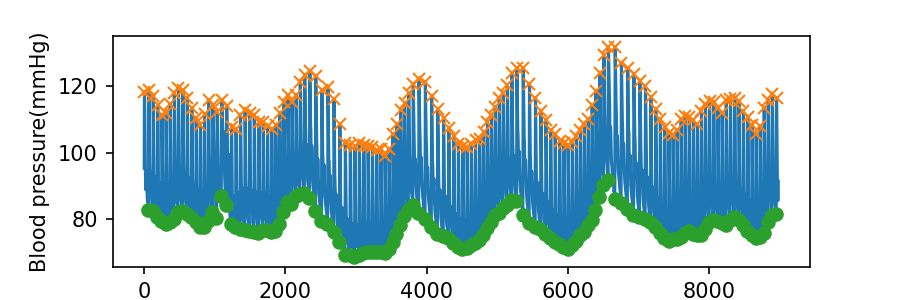

<IPython.core.display.Javascript object>


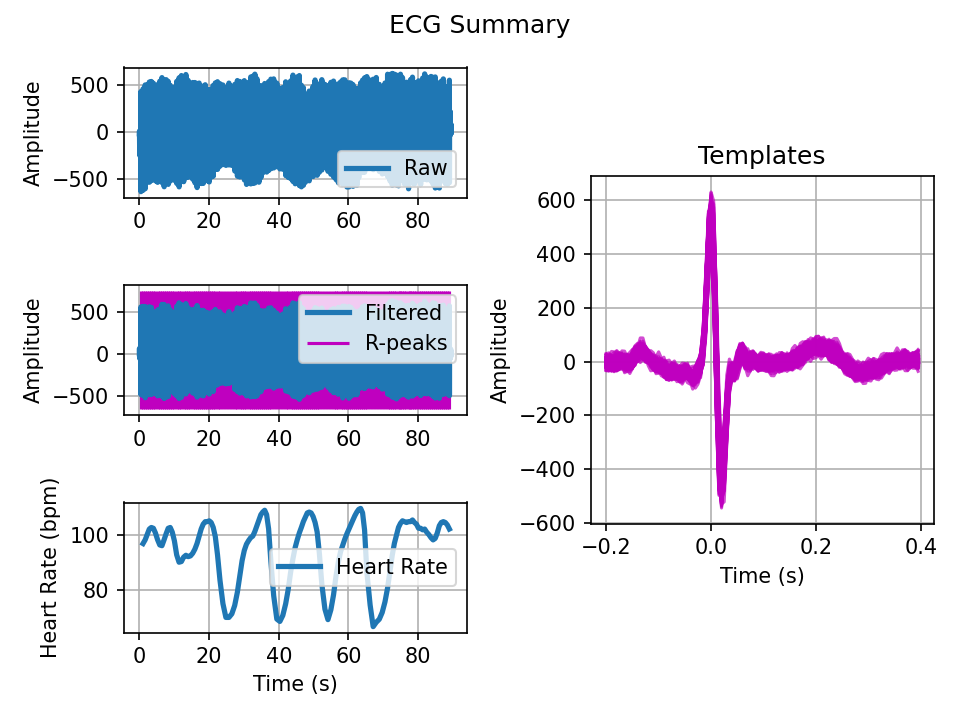

<IPython.core.display.Javascript object>


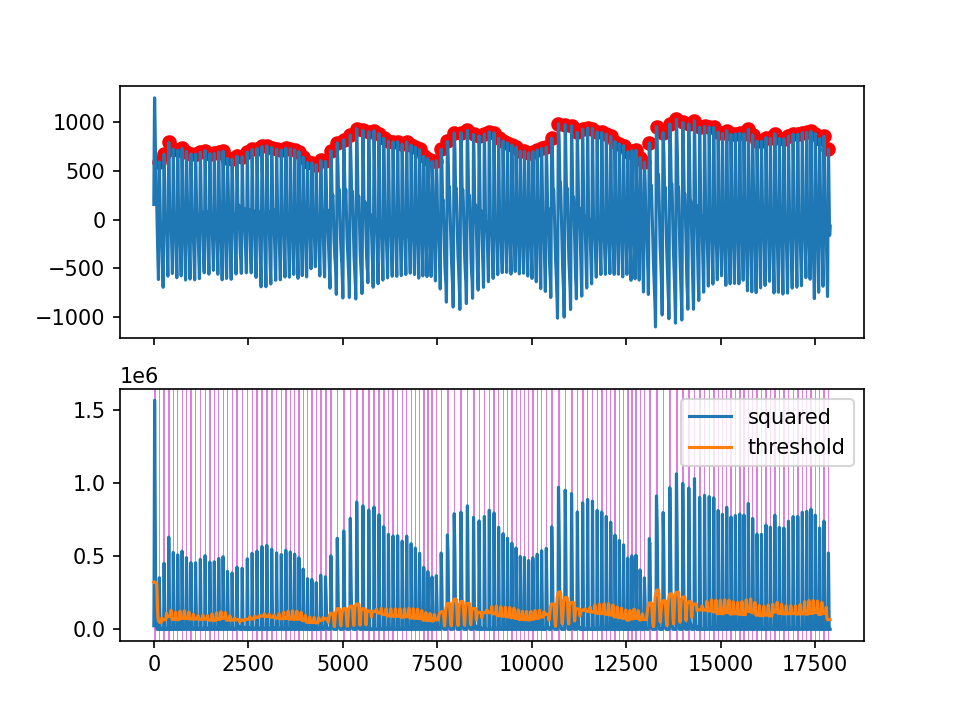

<IPython.core.display.Javascript object>


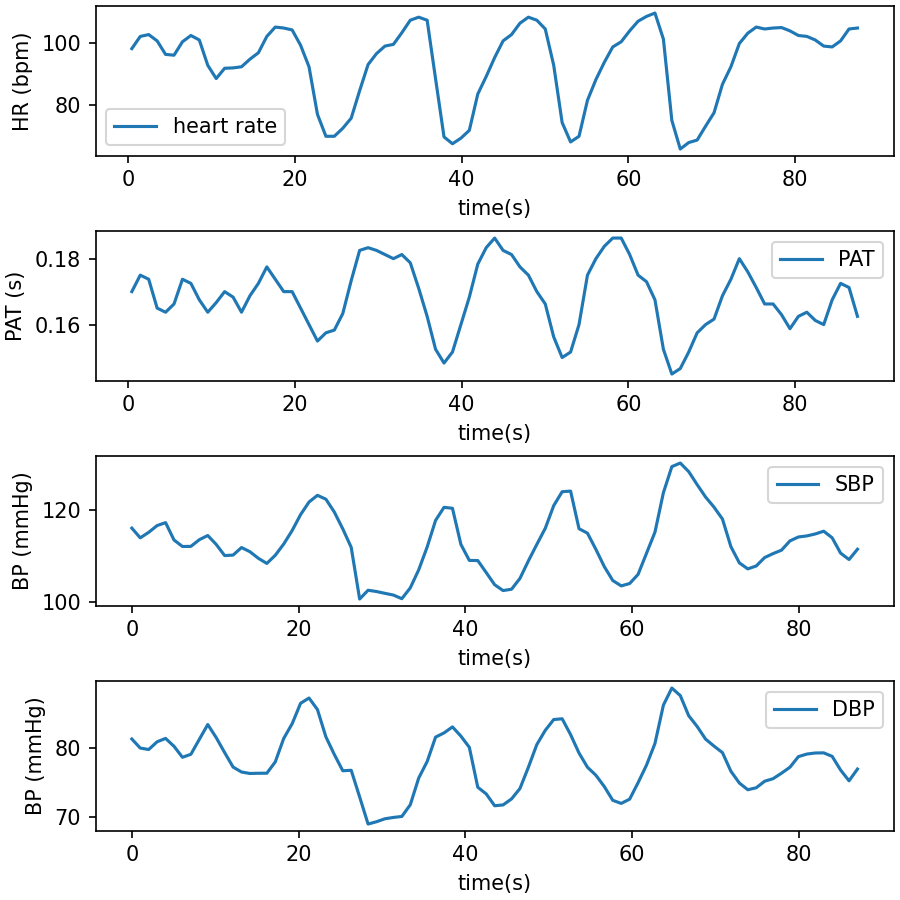

87 87


In [44]:
#1933
path_wav =  '../Jukka_216/CNAP_2022-02-16_20-30-20_001_waveform.csv'
path_bet =  '../Jukka_216/CNAP_2022-02-16_20-30-20_001_beats.csv'
path_sen = '../Jukka_216/2022-02-16-19-33-05/2022-02-16-19-33-05.csv'

abp = abp_sig(path_bet, path_wav)
ecg_f, ppg_f = ecg_ppg_show(path_sen)
ppg_maxamp, ppg_std, ppg_skew, ppg_kurto, ppg_aimean, ppg_lasimean, ppg_aistd, ppg_lasistd = ppg_features(ppg_f)
hr_lis = ecg_features(ecg_f)
pat_mx, pat_pk, pat_ft = pat_features(ecg_f, ppg_f)
sbp_lis, dbp_lis = sbp_dbp(abp)
visualize(ecg_f, hr_lis, pat_ft, sbp_lis, dbp_lis)
print(len(sbp_lis), len(pat_pk))

In [40]:

df_1933 = pd.DataFrame({'mxamp':ppg_maxamp, 
                          'std':ppg_std, 'skew':ppg_skew, 
                          'kurtosis':ppg_kurto, 
                          'aimean':ppg_aimean, 
                          'lasimean':ppg_lasimean, 
                          'aistd':ppg_aistd, 
                          'lasistd':ppg_lasistd,
                          'hr':hr_lis, 
                          'patmx':pat_mx, 
                          'patpk':pat_pk, 
                          'patft':pat_ft, 
                          'sbp':sbp_lis[-87:], 
                          'dbp':dbp_lis[-87:]})
df_1933

mxamp         std      skew  kurtosis    aimean  lasimean     aistd  \
0   1946.729352  424.597128 -0.583358 -0.116724 -0.076684  0.146667  0.046376   
1   1489.025342  374.044553 -0.398749 -0.639105 -0.109443  0.145000  0.065781   
2   1357.711611  372.590231 -0.334941 -0.809530 -0.138070  0.146667  0.052213   
3   1351.859635  372.622252 -0.326856 -0.811848  0.016829  0.150000  0.058712   
4   1330.439995  371.599604 -0.277201 -0.848514  0.036680  0.148750  0.037300   
..          ...         ...       ...       ...       ...       ...       ...   
82  1648.349920  454.933806 -0.313119 -0.754156 -0.002683  0.145000  0.015902   
83  1659.651143  448.757452 -0.422786 -0.687299 -0.050595  0.145000  0.047562   
84  1610.583462  436.938508 -0.561483 -0.606359 -0.111088  0.146667  0.030226   
85  1718.082386  451.968913 -0.571665 -0.592175 -0.161014  0.146667  0.015564   
86  1718.082386  438.507603 -0.482297 -0.586270 -0.090414  0.148750  0.079204   

     lasistd          hr    patmx    patpk    patft         sbp     dbp  
0   0.004714   98.092643 -0.01125  0.29125  0.17000  116.072000  81.240  
1   0.003536  101.983003 -0.22750  1.46500  0.17500  113.968000  79.934  
2   0.002357  102.564103 -0.22375  2.04000  0.17375  115.162000  79.724  
3   0.004082  100.558659  0.22125  1.52000  0.16500  116.630000  80.840  
4   0.004146   96.256684  0.13000  1.53750  0.16375  117.266000  81.324  
..       ...         ...      ...      ...      ...         ...     ...  
82  0.000000   98.901099  0.21875  1.50750  0.16000  115.404000  79.242  
83  0.000000   98.630137 -0.01250  1.51000  0.16750  113.977500  78.740  
84  0.002357  100.558659 -0.24000  2.08500  0.17250  110.652000  76.768  
85  0.002357  104.347826 -0.20875  1.45000  0.17125  109.262000  75.214  
86  0.004146  104.651163  0.22000  1.42750  0.16250  111.496667  76.910  

[87 rows x 14 columns]

In [41]:
df_1933.to_csv("../j_prepared_data/1933_all.csv", index = False)